# Effect of Yesterday's Load on Performance and Wellness

After applying mixed models with random intercepts and GEE, one other interesting thing to explore owuld be to see if there is any specific relationship between yesterday's training load on the performance and wellness.<br><br>
In this notebook we will investigate this by first creating the proper dataset that includes yesterday's daily loads,  then merging it with wellness or performance data and then applying GEEs and random mixed models to find the best fit and compare their coefficients.


In [260]:
import pandas as pd
import numpy as np
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
import warnings


## Helper functions

In [261]:
# Helper function to draw scatter plots given the dataframe and appropriate columns
def scatter_plot(df, x, y, title=None):
    df.plot.scatter(x, y)
    if title:
        plt.title(title)
    plt.show()
    

# Helper function to remove the outliers based on the IQR rule
def removeOutliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1

    new_df = df[(df[column_name] > Q1 - (1.5 * IQR)) & 
                (df[column_name] < Q3 + (1.5 * IQR))]
    return new_df 

# Helper function for plotting two different responses when they are on different scales
def group_by_multiple_plots(data, group_by, group_title, x_axis_name, y1_axis_name, y2_axis_name):
    
    grouped = data.groupby(group_by)

    for name,group in grouped:
        fig = plt.figure(figsize=(12,3))
        ax1 = fig.add_subplot(111)
        group.plot.line(ax = ax1, color = 'red',x = x_axis_name,y = y1_axis_name)
        ax1.set_ylabel('MaxSpeedInGame')
        ax3 = ax1.twinx()
        group.plot.line(ax = ax3, color = 'blue',x = x_axis_name,y = y2_axis_name)
        ax3.set_ylabel('YesterdayLoad')
        ax1.set_title(group_title + str(name), fontsize = 15)

    plt.show()
    plt.close()

## Reading data

In [262]:
rpe_df = pd.read_csv('./processed_data/processed_rpe.csv')
rpe_df = rpe_df.drop(columns=['Unnamed: 0'])
print(rpe_df.head())

         Date  PlayerID  Training SessionType  Duration  RPE  SessionLoad  \
0  2017-08-01        15         1    Strength      60.0  4.0        240.0   
1  2017-08-01         1         1       Speed      60.0  3.0        180.0   
2  2017-08-01         1         1    Strength      90.0  4.0        360.0   
3  2017-08-01         3         1       Speed      45.0  5.0        225.0   
4  2017-08-01         3         1    Strength      90.0  5.0        450.0   

   DailyLoad  AcuteChronicRatio  ObjectiveRating  FocusRating  \
0      300.0               4.29              6.0          7.0   
1      540.0               4.29              0.0          0.0   
2      540.0               4.29              0.0          0.0   
3      675.0               4.29              7.0          7.0   
4      675.0               4.29              7.0          7.0   

   BestOutOfMyself  AcuteLoad  ChronicLoad  
0              2.0      42.86         10.0  
1              2.0      77.14         18.0  
2          

In [263]:
wellness_df = pd.read_csv('./processed_data/processed_wellness.csv')
wellness_df = wellness_df.drop(columns=['Unnamed: 0'])
print(wellness_df.head())

         Date  PlayerID  MonitoringScore  Fatigue  Soreness  Desire  \
0  2018-07-21         1               13        3         3       2   
1  2018-07-21         2               19        4         3       4   
2  2018-07-21         3               19        3         3       5   
3  2018-07-21         4               15        2         3       5   
4  2018-07-21         5               20        5         3       4   

   Irritability  SleepHours  SleepQuality  Menstruation  ...  Nutrition  \
0             3        8.00             2             0  ...          3   
1             4        8.00             4             0  ...          3   
2             4        8.00             4             1  ...          3   
3             4        6.50             1             0  ...          3   
4             4        7.25             4             1  ...          2   

   TrainingReadiness  StandardizedMonitoringScore  StandardizedPain  \
0                  0                    -1.448934  

In [264]:
gps_df = pd.read_csv('./processed_data/processed_gps.csv')
gps_df = gps_df.drop(columns=['Unnamed: 0'])
print(gps_df.head())

         Date  GameID Outcome  TeamPoints  PlayerID  MaxSpeedInGame  \
0  2017-11-30       1       W          19         2        7.284728   
1  2017-11-30       1       W          19         3        6.852436   
2  2017-11-30       1       W          19         4        7.267784   
3  2017-11-30       1       W          19         6        6.338894   
4  2017-11-30       1       W          19         7        7.065283   

   MaxAccelImpulseInGame  
0               4.423615  
1               4.888893  
2               5.694449  
3               4.777782  
4               4.091273  


## Create yesterday's dataset

To do this we can just shift the dates by 1 day and then merge iy with the wellness or performance data. This way for ech day in the new merged datsets we will basically have yesterday's training load.

In [265]:
yesterday_rpe = rpe_df.copy()[['Date','PlayerID','Training','SessionLoad','RPE','DailyLoad']]
yesterday_rpe['Date'] = pd.to_datetime(yesterday_rpe['Date'], format='%Y-%m-%d')

# Add one day to all dates
yesterday_rpe['Date'] = pd.DatetimeIndex(yesterday_rpe['Date']) + pd.DateOffset(1)
yesterday_rpe = yesterday_rpe.rename(columns = {'DailyLoad':'YesterdayLoad'})

yesterday_rpe.head()

,Date,PlayerID,Training,SessionLoad,RPE,YesterdayLoad
0,2017-08-02,15,1,240.0,4.0,300.0
1,2017-08-02,1,1,180.0,3.0,540.0
2,2017-08-02,1,1,360.0,4.0,540.0
3,2017-08-02,3,1,225.0,5.0,675.0
4,2017-08-02,3,1,450.0,5.0,675.0


# Training load on the day before and today's wellness

To do this we first need to merge the data with wellness data:

In [266]:
wellness_df['Date'] = pd.to_datetime(wellness_df['Date'],format='%Y-%m-%d')

# Merge yesterday training load with wellness data
wellness_with_yesterday_training = yesterday_rpe.merge(wellness_df,
    how='inner', on= ['Date','PlayerID'])[['Date','PlayerID','YesterdayLoad',
                                           'MonitoringScore','TrainingReadiness',
                                           'Pain','Illness','Nutrition',
                                           'wellness']].drop_duplicates()


In [267]:
# Sanity check
wellness_with_yesterday_training[(wellness_with_yesterday_training['PlayerID'] == 1)]

,Date,PlayerID,YesterdayLoad,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,wellness
315,2017-08-17,1,0.0,19,80,1,3,3,1.580689
346,2017-08-18,1,510.0,20,85,1,3,3,1.850592
378,2017-08-19,1,1230.0,21,0,1,3,3,2.120494
408,2017-08-20,1,0.0,20,100,1,3,3,1.850592
454,2017-08-22,1,670.0,17,85,1,3,3,1.040885
...,...,...,...,...,...,...,...,...,...
8239,2018-07-15,1,0.0,21,0,1,3,3,2.120494
8248,2018-07-17,1,240.0,18,0,1,3,3,1.310787
8264,2018-07-18,1,180.0,15,0,1,3,3,0.501081
8282,2018-07-19,1,0.0,20,0,1,3,3,1.850592


In [268]:
processed_wellness = wellness_with_yesterday_training.copy()

# Since wellness values are really small we need to rescale training loads as well
processed_wellness['YesterdayLoad'] = StandardScaler().fit_transform(wellness_with_yesterday_training[['YesterdayLoad']])

processed_wellness[(processed_wellness['PlayerID'] == 2)]

,Date,PlayerID,YesterdayLoad,MonitoringScore,TrainingReadiness,Pain,Illness,Nutrition,wellness
316,2017-08-17,2,-0.921055,18,80,1,3,2,-0.627324
343,2017-08-18,2,1.005407,19,75,1,3,3,1.580689
385,2017-08-19,2,1.701718,22,0,1,3,3,2.390396
409,2017-08-20,2,-1.013897,23,0,0,3,2,-2.389963
423,2017-08-21,2,-1.013897,20,85,1,3,2,-0.087520
...,...,...,...,...,...,...,...,...,...
8238,2018-07-15,2,-0.874634,25,0,0,3,3,0.087952
8250,2018-07-17,2,-0.456848,19,0,0,3,2,-3.469572
8266,2018-07-18,2,-0.364006,24,0,1,3,2,0.992089
8283,2018-07-19,2,-1.013897,22,0,0,3,3,-0.721754


Before applying any model, it is again a good idea to visualize yesterday's load vs wellness over all days for each players to see if we can observe any obvious relationship or pattern.

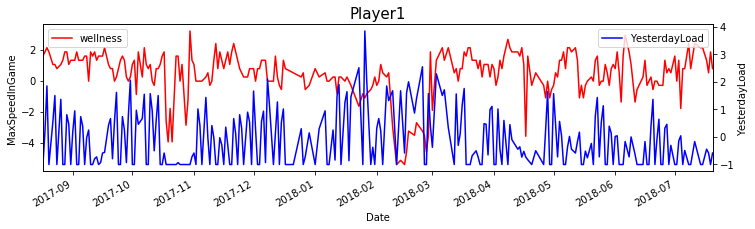

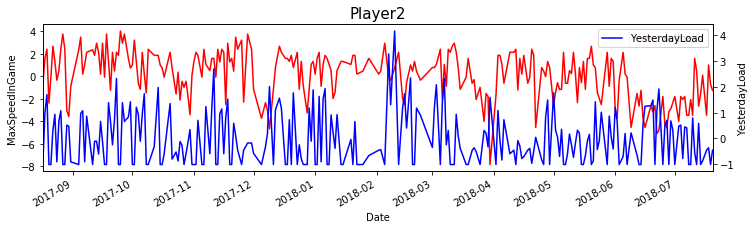

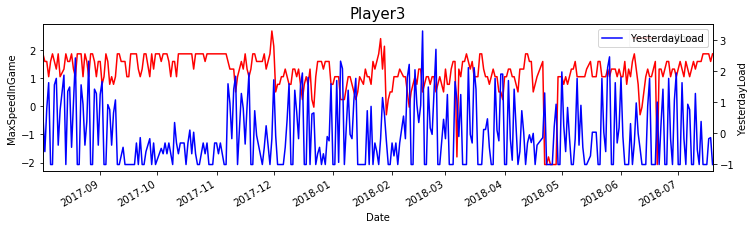

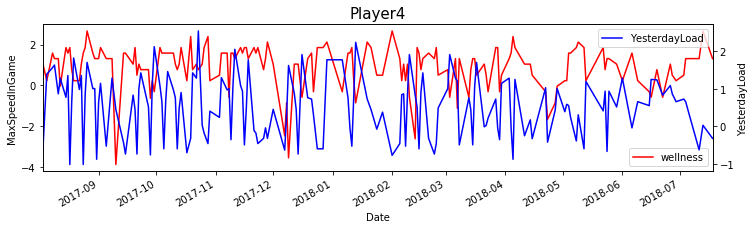

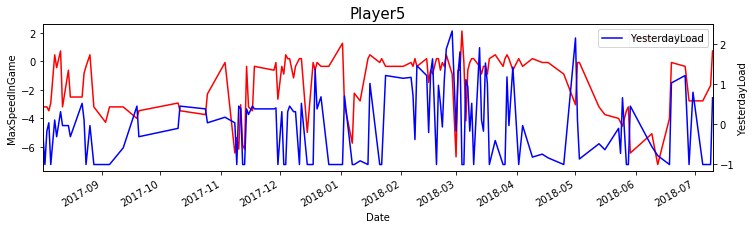

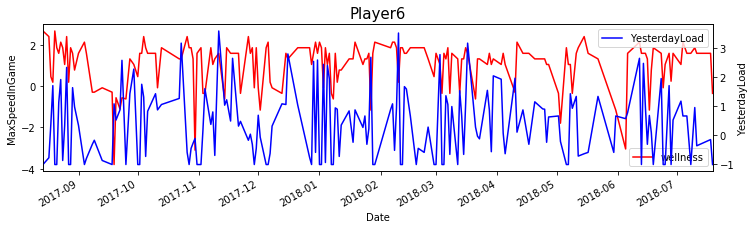

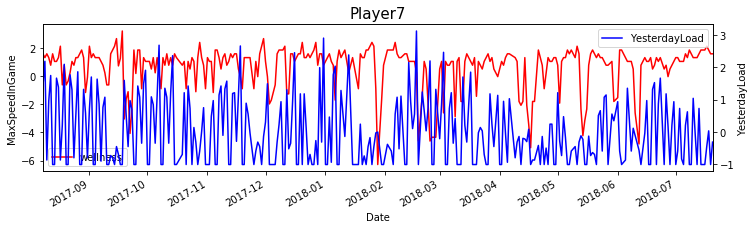

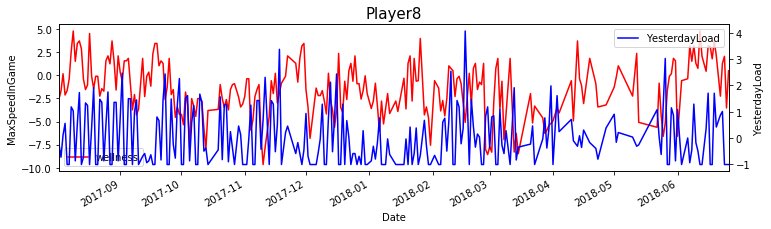

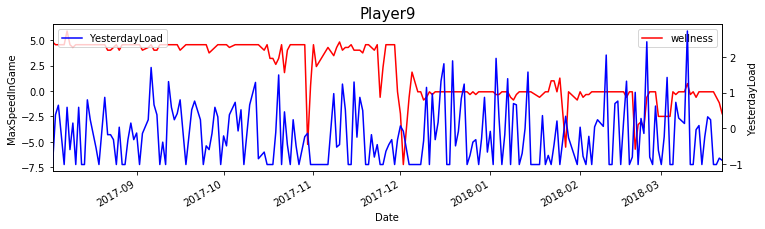

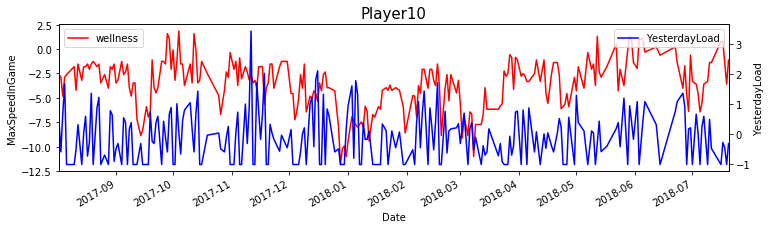

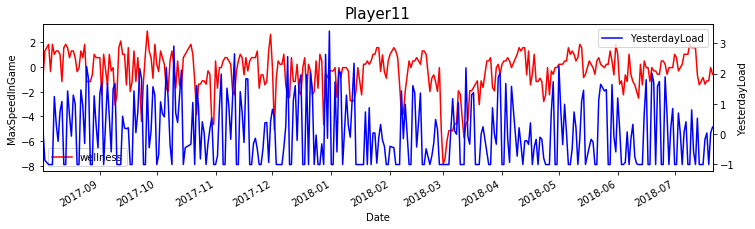

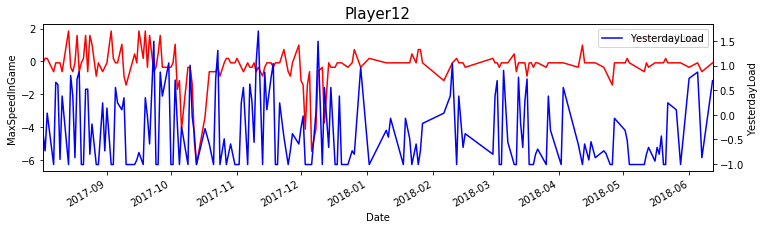

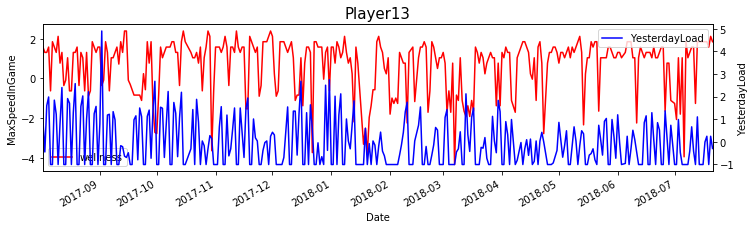

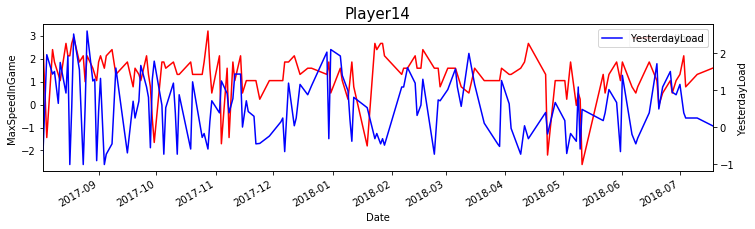

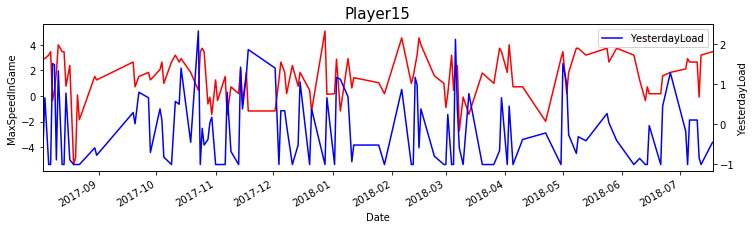

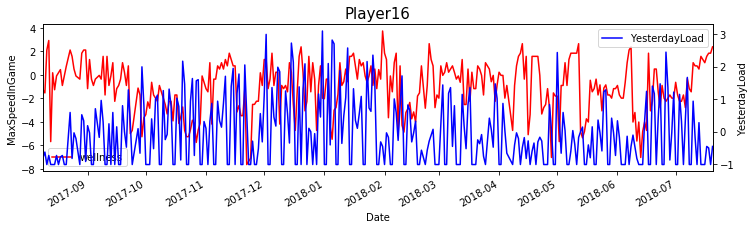

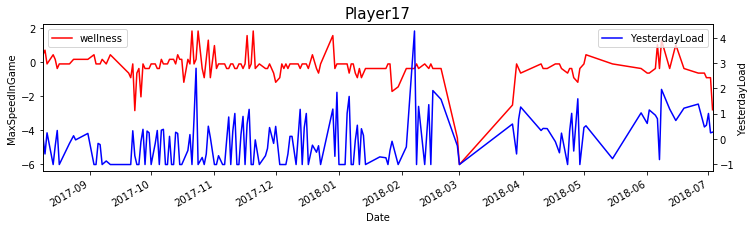

In [269]:
group_by_multiple_plots(data = processed_wellness, group_by = 'PlayerID', group_title = 'Player',
                        x_axis_name = 'Date', y1_axis_name = 'wellness', y2_axis_name = 'YesterdayLoad')

We can see that the measures for both yesterday's load and the wellness varies a lot as time goes by. We can also see that within short intervals sometimes there are sudden drops or peaks. Therefore just based on the graphs, it is hard to see any clear pattern or trend, so let's invetigate this further by applying GEEs and random intercept mixed models.

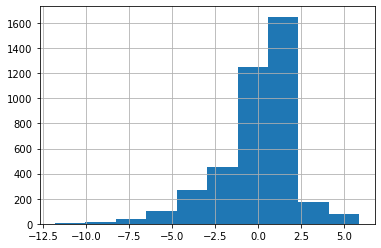

In [270]:
processed_wellness['wellness'].hist()

As we can see from the histogram above, the wellness data distribution has a longer tail on its left, so before fitting the model it is a good idea to remove the outliers using the IQR rule.

                               GEE Regression Results                              
Dep. Variable:                    wellness   No. Observations:                 3827
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                 117
                      Estimating Equations   Max. cluster size:                 343
Family:                           Gaussian   Mean cluster size:               225.1
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Tue, 10 Dec 2019   Scale:                           3.032
Covariance type:                    robust   Time:                         18:00:23
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.2907      0.253      1.147      0.251      -0.206       0.78

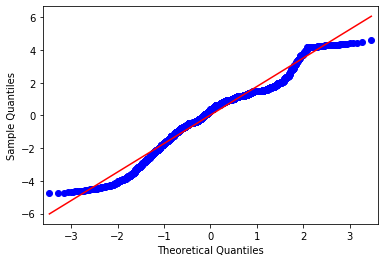

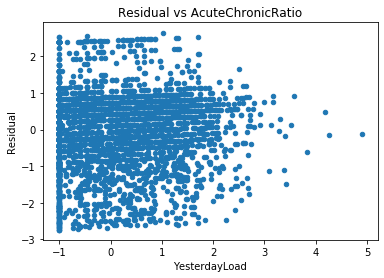

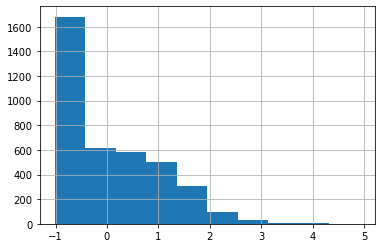

In [271]:
fam = sm.families.Gaussian()
ind = sm.cov_struct.Exchangeable()

# Remove the outliers of the welless data
processed_wellness = removeOutliers(processed_wellness.copy(), 'wellness')

mod = smf.gee("wellness ~ YesterdayLoad", "PlayerID", processed_wellness, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())

qqplot(res.resid, line='s')
plt.show()


processed_wellness['Residual'] = (res.resid - res.resid.mean()) / res.resid.std()

scatter_plot(processed_wellness, 'YesterdayLoad', 'Residual', 'Residual vs AcuteChronicRatio')
processed_wellness['YesterdayLoad'].hist()

The very small p_value for the yesterday's load coefficient shows that there is a statistically significant negative relationship between yesterday's training load and today's wellness. However, from the qqplot we can also see that the residuals are not quite normally distributed, with the issue occuring at the extreme values of the residuals. This might indicate that the GEE model is not a really good fit to the data. So in order to have higher confidence about the relationship between yesterday's load and today's wellness we can try random intercept mixed models as well:

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: wellness  
No. Observations: 3827    Method:             REML      
No. Groups:       17      Scale:              2.1308    
Min. group size:  117     Likelihood:         -6920.4409
Max. group size:  343     Converged:          Yes       
Mean group size:  225.1                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.291    0.261  1.112 0.266 -0.222  0.803
YesterdayLoad -0.097    0.024 -4.033 0.000 -0.144 -0.050
Group Var      1.152    0.283                           



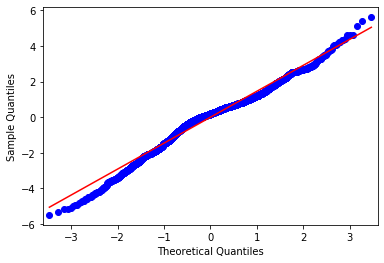

In [272]:
mixed = smf.mixedlm("wellness ~ YesterdayLoad", processed_wellness, groups = processed_wellness["PlayerID"])
mixed_fit = mixed.fit()

print(mixed_fit.summary())
qqplot(mixed_fit.resid, line='s')
plt.show()

We can see that the coefficients and the p_values are really similar to the GEE model (as it was mentioned in the previous notebooks GEE with exchangeable correlation structure is annalogus to a mixed model with random intercepts).  However in this case from the qqplots we can see that the random mixed model is a better fit compared to the gee model so we can rely on the mixed model's estimates instead of the GEE's.

The model suggests that the coefficient for yesterday's load is -0.1, which means that a unit increase in yesterday's load will result in 0.1 decrease in wellness. We need to note that here yesterday's load was standardized, so a unit change in yesterday's load is a relatively big chane while the -0.1 in wellness is relatively small. To contextualize this better, we can see what percentile the median player's wellness would change to if the daily load was increased by one unit: 

In [273]:
processed_wellness['wellness'].quantile(0.5)

0.5010807428339006

In [274]:
median_wellness = processed_wellness['wellness'].median()
new_wellness = median_wellness - 0.1
print(new_wellness)

0.4010807428339006


In [275]:
processed_wellness['wellness'].quantile(0.46)

0.23922184054408147

We can see that decreasing the median player's wellness by 0.1 m/s would move them from the 50th percentile to the 46th percentile which shows that the effect of daily load on wellness is realtively small.

# Performance vs yesterday's daily load

Again,  first we need to first merge the yesterday's training laod with performance data.

In [276]:
gps_df['Date'] = pd.to_datetime(gps_df['Date'],format='%Y-%m-%d')

speed_vs_yesterday_load = gps_df.merge(yesterday_rpe,
    how='inner', on= ['Date','PlayerID'])[['Date','PlayerID','YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']].drop_duplicates()

processed_speed = speed_vs_yesterday_load.copy()

# Removing the outliers in the performance
processed_speed = removeOutliers(processed_speed.copy(), 'MaxSpeedInGame')

# It is better to standardize all columns to make them be on the same scale
processed_speed[['YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']] = StandardScaler().fit_transform(processed_speed[['YesterdayLoad','MaxSpeedInGame','MaxAccelImpulseInGame']])

Again before applying any model it is a good idea to visualize max speed of each player vs their yesterday's training load to see if there are any visible patterns.

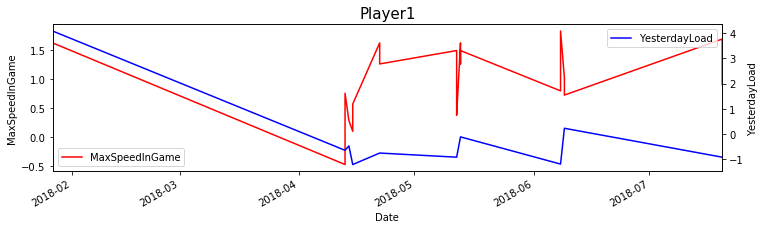

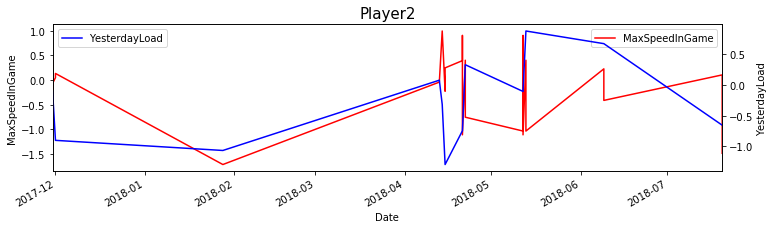

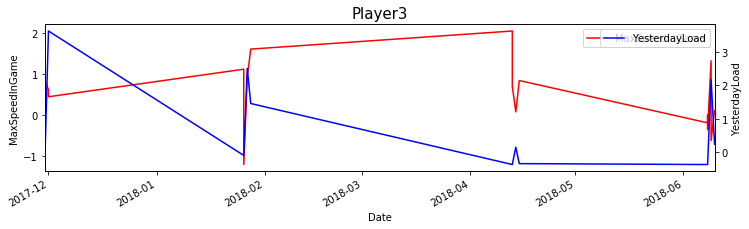

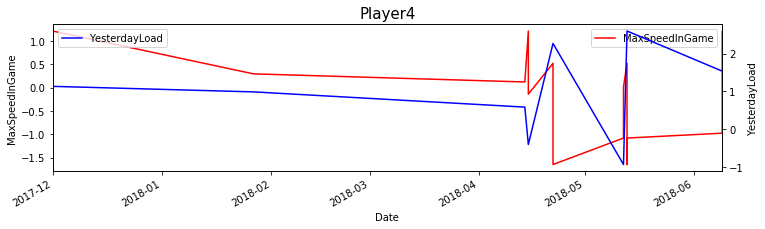

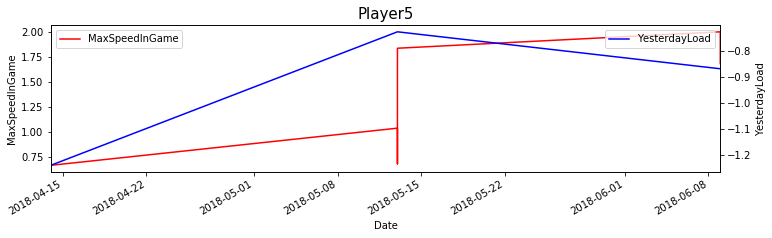

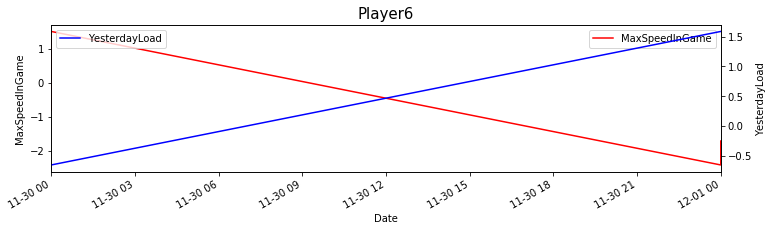

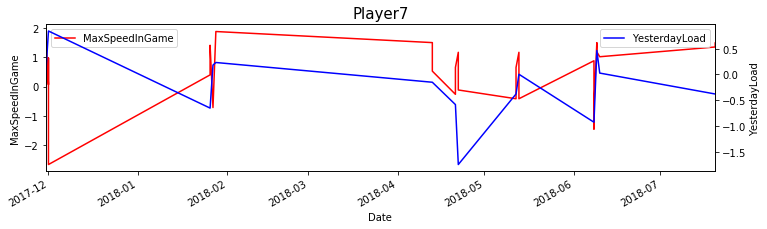

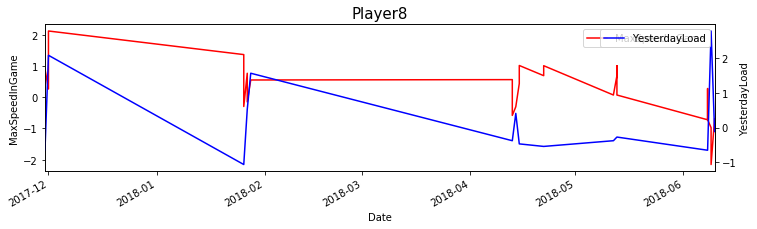

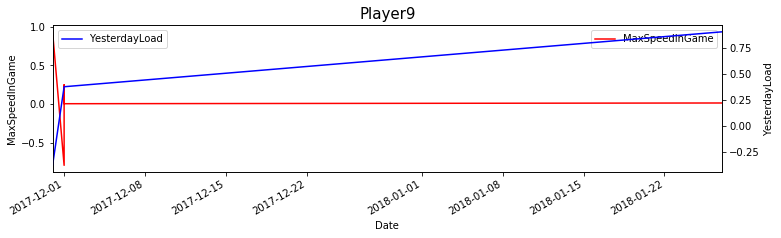

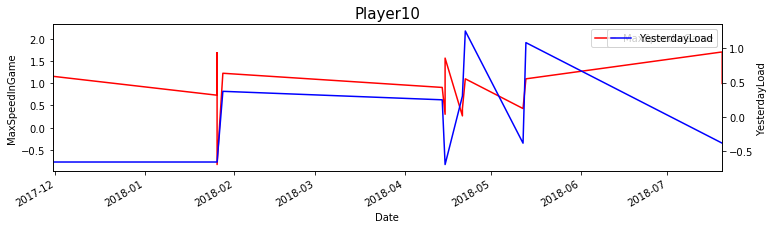

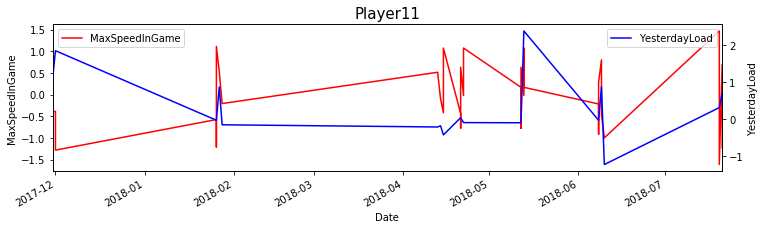

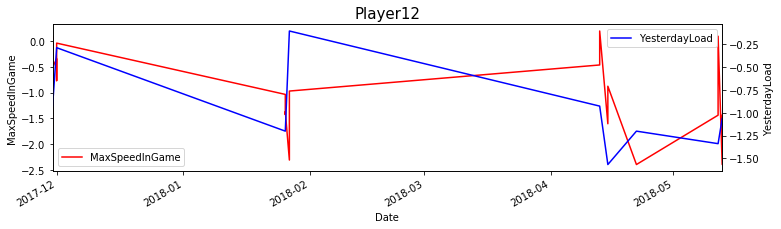

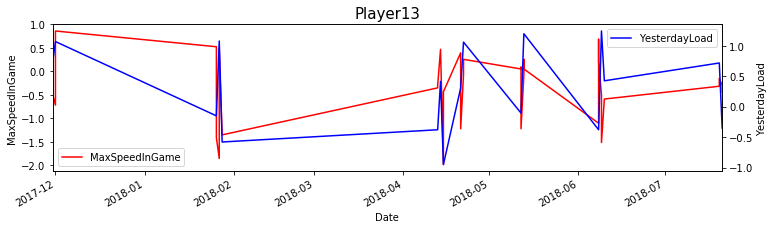

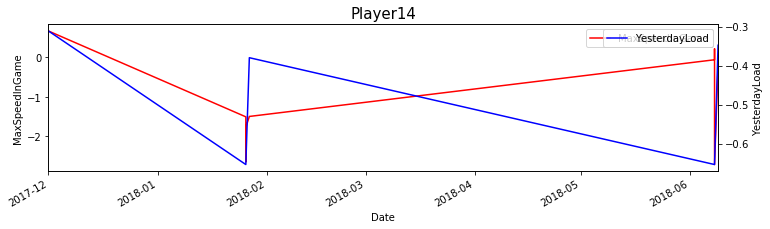

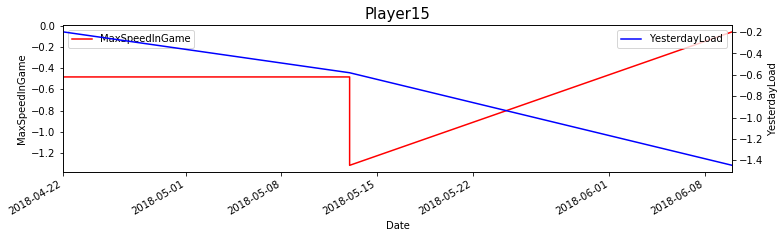

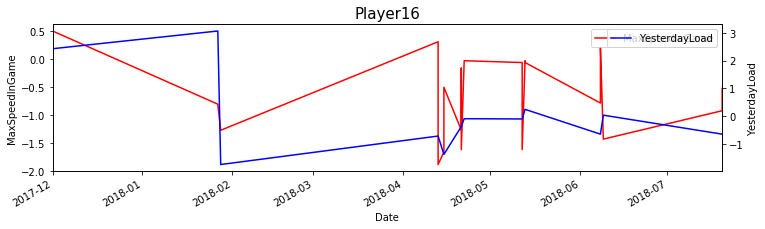

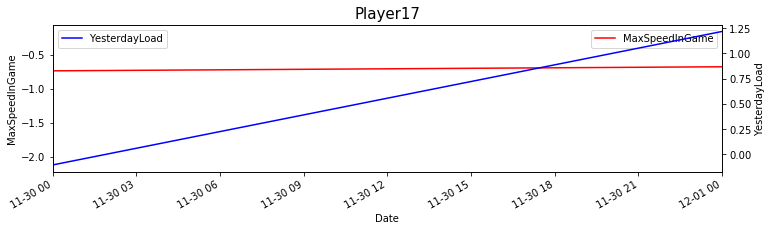

In [277]:
group_by_multiple_plots(data = processed_speed, group_by = 'PlayerID', group_title = 'Player',
                        x_axis_name = 'Date', y1_axis_name = 'MaxSpeedInGame', y2_axis_name = 'YesterdayLoad')

In the graphs above we can see that the performance and load measures vary more for some players over time compared to other players (however this might also depend on the number of games they participated in). Some of the plots above might show that there is an inverse relationship between yesterday's load and performance (this kind of pattern is especially visible for player 3) however to make robust conclusions we need to fit GEE or mixed models to investigate this sort of relationship further:

                               GEE Regression Results                              
Dep. Variable:              MaxSpeedInGame   No. Observations:                  314
Model:                                 GEE   No. clusters:                       17
Method:                        Generalized   Min. cluster size:                   4
                      Estimating Equations   Max. cluster size:                  38
Family:                           Gaussian   Mean cluster size:                18.5
Dependence structure:         Exchangeable   Num. iterations:                     5
Date:                     Tue, 10 Dec 2019   Scale:                           1.008
Covariance type:                    robust   Time:                         18:00:38
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.0389      0.160     -0.243      0.808      -0.353       0.27

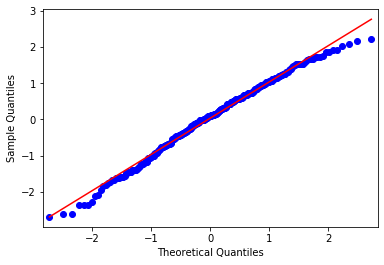

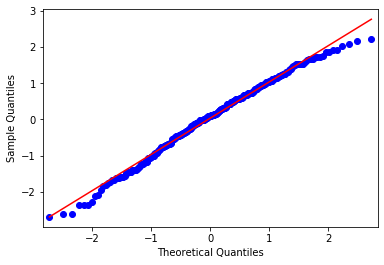

In [278]:
mod = smf.gee("MaxSpeedInGame ~ YesterdayLoad", "PlayerID", processed_speed, cov_struct=ind, family=fam)
res = mod.fit()
print(res.summary())
qqplot(res.resid, line = 's')

The QQplots show that the model is a good fit and we can also see that yesterday's load coefficient in the GEE model is negative; however, since p_value is really large, it shows that we can not reject the null hypothesis (which is there is no relationship between performance on a day and its previous day's daily load). So we can not make any conclusions based on the GEE model. We can also try fitting the random intercept mixed model to make sure there is indeed not a significant relationship between performance and the training load on the day before. 

           Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: MaxSpeedInGame
No. Observations: 314     Method:             REML          
No. Groups:       17      Scale:              0.6946        
Min. group size:  4       Likelihood:         -409.9228     
Max. group size:  38      Converged:          Yes           
Mean group size:  18.5                                      
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept         -0.050    0.169 -0.298 0.765 -0.382  0.281
YesterdayLoad     -0.002    0.053 -0.039 0.969 -0.106  0.102
Group Var          0.426    0.216                           



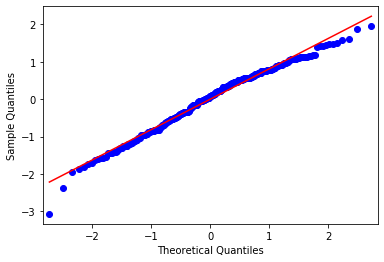

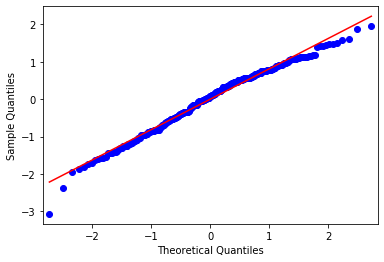

In [279]:
mixed = smf.mixedlm("MaxSpeedInGame ~ YesterdayLoad", processed_speed, groups = processed_speed["PlayerID"])
mixed_fit = mixed.fit()

print(mixed_fit.summary())
qqplot(mixed_fit.resid, line='s')

Again, we can see similar results to the GEE model. QQplots show that the random mixed model was also a good fit, however the large p_value of the negative coefficient associated with yesterday's load suggests that we can not be confident about the relationship between performance and the training load on the day before.